In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --quiet underthesea sentencepiece tensorflow keras matplotlib seaborn nltk rouge-score

In [ ]:
import os, re, unicodedata, pickle, warnings, json
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention
from sklearn.model_selection import train_test_split
from google.colab import drive
from underthesea import word_tokenize

# Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

warnings.filterwarnings('ignore')
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
# ================= CELL 2: TIỀN XỬ LÝ DỮ LIỆU (PREPROCESSING) ==================
# Cấu hình đường dẫn
DATA_PATH = "/content/drive/MyDrive/dataset/dataset_set_clean.json"
MAPPING_PATH = "/content/drive/MyDrive/dataset/edu_mapping.txt"
TOKENIZER_DIR = "/content/drive/MyDrive/Tranfor/" # Nơi lưu tokenizer

if not os.path.exists(TOKENIZER_DIR):
    os.makedirs(TOKENIZER_DIR)

In [ ]:
# 1. Hàm load mapping viết tắt (nếu có)
def load_contraction_mapping(file_path: str) -> dict:
    mapping = {}
    if not os.path.exists(file_path):
        return mapping
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"): continue
            if "=" in line: k, v = line.split("=", 1)
            elif ":" in line: k, v = line.split(":", 1)
            else: continue
            mapping[k.strip().lower()] = v.strip().lower()
    return mapping

In [ ]:
# 2. Hàm làm sạch văn bản (QUAN TRỌNG)
def clean_text(text: str, lowercase=False, mapping=None) -> str:
    if not text: return ""

    # Chuẩn hóa Unicode
    text = unicodedata.normalize("NFC", str(text))

    # Thay thế từ viết tắt
    if mapping:
        for k, v in mapping.items():
            pattern = r"\b" + re.escape(k) + r"\b"
            text = re.sub(pattern, v, text, flags=re.IGNORECASE)

    # Xóa HTML tags
    text = re.sub(r"<.*?>", " ", text)

    # Giữ lại chữ cái, số, và dấu câu cơ bản
    text = "".join(ch if (ch.isalpha() or ch.isspace() or ch.isdigit() or ch in ['/', '-']) else " " for ch in text)

    if lowercase:
        text = text.lower()

    # Tách từ tiếng Việt (Word Segmentation)
    tokens = word_tokenize(text, format="text").split()
    text = ' '.join(tokens)

    # Xóa khoảng trắng thừa
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
# 3. Load và xử lý DataFrame
print("⏳ Đang load và xử lý dữ liệu (có thể mất vài phút)...")
try:
    df = pd.read_json(DATA_PATH, encoding='utf-8')
except ValueError: # Fallback nếu file json lỗi định dạng
    data = []
    with open(DATA_PATH, 'r', encoding='utf-8') as f:
        for line in f:
            try: data.append(json.loads(line))
            except: pass
    df = pd.DataFrame(data)

# Load mapping
contraction_mapping = load_contraction_mapping(MAPPING_PATH)

⏳ Đang load và xử lý dữ liệu (có thể mất vài phút)...


In [ ]:
# Áp dụng Clean Text
# Lưu ý: Cột dữ liệu đầu vào là 'content', nhãn là 'description'
df['clean_content'] = df['content'].apply(lambda x: clean_text(x, lowercase=True, mapping=contraction_mapping))
df['clean_summary'] = df['description'].apply(lambda x: clean_text(x, lowercase=True, mapping=contraction_mapping))

# Thêm startseq và endseq cho decoder
df['clean_summary'] = df['clean_summary'].apply(lambda x: 'startseq ' + x + ' endseq')

print(f"✅ Đã xử lý xong {len(df)} dòng dữ liệu.")
print("Mẫu Content:", df['clean_content'].iloc[0][:100])
print("Mẫu Summary:", df['clean_summary'].iloc[0])

✅ Đã xử lý xong 14709 dòng dữ liệu.
Mẫu Content: quyết_định chia_sẻ câu_chuyện của bản_thân dược_sĩ đỗ thùy anh sn 1996 muốn truyền cảm_hứng học_tập 
Mẫu Summary: startseq đỗ thùy anh là dược_sĩ lâm_sàng tại bệnh_viện nhi trung_ương sau 5 năm công_tác thùy anh quyết_định gác lại nhiều kế_hoạch trong công_việc và cuộc_sống riêng để đi du_học dù cô vừa kết_hôn endseq


In [ ]:
def word_count(text):
    return len(str(text).split())

# Thêm cột độ dài
df["content_len"] = df["clean_content"].apply(word_count)
df["summary_len"] = df["clean_summary"].apply(word_count)

print("Thống kê content:")
print(df["content_len"].describe(percentiles=[.5, .75, .9, .95, .99]))

print("\nThống kê summary:")
print(df["summary_len"].describe(percentiles=[.5, .75, .9, .95, .99]))

# Vẽ biểu đồ phân phối độ dài content
plt.figure(figsize=(10,5))
plt.hist(df["content_len"], bins=50, color="skyblue", edgecolor="black")
plt.axvline(400, color='red', linestyle='dashed', linewidth=1, label="400 tokens")
plt.axvline(1500, color='orange', linestyle='dashed', linewidth=1, label="1500 tokens")
plt.title("Phân phối độ dài văn bản (content)")
plt.xlabel("Số từ")
plt.ylabel("Số bài")
plt.legend()
plt.show()

# Vẽ biểu đồ phân phối độ dài summary
plt.figure(figsize=(8,4))
plt.hist(df["summary_len"], bins=40, color="lightgreen", edgecolor="black")
plt.axvline(40, color='red', linestyle='dashed', linewidth=1, label="40 tokens")
plt.title("Phân phối độ dài summary (description)")
plt.xlabel("Số từ")
plt.ylabel("Số bài")
plt.legend()
plt.show()

In [ ]:
# ================= CELL 3: TOKENIZER & PADDING ==================
MAX_VOCAB_IN = 40000
MAX_VOCAB_OUT = 20000
MAX_TEXT_LEN = 600
MAX_SUMMARY_LEN = 50

In [ ]:
# Kiểm tra xem đã có tokenizer chưa, nếu chưa thì tạo mới
x_tokenizer_path = os.path.join(TOKENIZER_DIR, 'x_tokenizer_tranformer.pkl')
y_tokenizer_path = os.path.join(TOKENIZER_DIR, 'y_tokenizer_tranformer.pkl')

if os.path.exists(x_tokenizer_path) and os.path.exists(y_tokenizer_path):
    print("📥 Đang load Tokenizer từ file...")
    with open(x_tokenizer_path, 'rb') as f: x_tokenizer = pickle.load(f)
    with open(y_tokenizer_path, 'rb') as f: y_tokenizer = pickle.load(f)
else:
    print("⚙️ Đang fit Tokenizer mới (lần đầu chạy sẽ lâu)...")
    x_tokenizer = Tokenizer(num_words=MAX_VOCAB_IN, oov_token='<OOV>')
    x_tokenizer.fit_on_texts(df['clean_content'])

    y_tokenizer = Tokenizer(num_words=MAX_VOCAB_OUT, oov_token='<OOV>')
    y_tokenizer.fit_on_texts(df['clean_summary'])

    # Lưu lại để lần sau không phải chạy lại
    with open(x_tokenizer_path, 'wb') as f: pickle.dump(x_tokenizer, f)
    with open(y_tokenizer_path, 'wb') as f: pickle.dump(y_tokenizer, f)

vocab_size_in = min(MAX_VOCAB_IN, len(x_tokenizer.word_index) + 1)
vocab_size_out = min(MAX_VOCAB_OUT, len(y_tokenizer.word_index) + 1)
reverse_target_word_index = y_tokenizer.index_word

📥 Đang load Tokenizer từ file...


In [ ]:
# Padding dữ liệu
print("🔄 Đang chuyển đổi text sang sequence...")
X = x_tokenizer.texts_to_sequences(df['clean_content'])
X = pad_sequences(X, maxlen=MAX_TEXT_LEN, padding='post')

Y = y_tokenizer.texts_to_sequences(df['clean_summary'])
Y = pad_sequences(Y, maxlen=MAX_SUMMARY_LEN, padding='post')

🔄 Đang chuyển đổi text sang sequence...


In [ ]:
# Tách Y thành Input (bỏ từ cuối) và Output (bỏ từ đầu)
Y_in = Y[:, :-1]   # Input cho Decoder
Y_out = Y[:, 1:]   # Label thực tế (Target)

# Chia Train/Val
x_train, x_val, y_train_in, y_val_in, y_train_out, y_val_out = train_test_split(
    X, Y_in, Y_out, test_size=0.1, random_state=42
)
print("✅ Shape Train:", x_train.shape, y_train_in.shape)
print("✅ Shape Target:", y_train_out.shape)

✅ Shape Train: (13238, 600) (13238, 49)
✅ Shape Target: (13238, 49)


In [ ]:
# ================= CELL 4: XÂY DỰNG MODEL OPTIMIZED (BƯỚC 2) ==================

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        # --- BẮT ĐẦU SỬA: Lưu các tham số vào self ---
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        # --- KẾT THÚC SỬA ---

        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return self.token_emb(inputs) + positions

    def compute_mask(self, inputs, mask=None):
        return self.token_emb.compute_mask(inputs, mask)

    def get_config(self):
        config = super().get_config()
        config.update({
            "maxlen": self.maxlen,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        # --- BẮT ĐẦU SỬA: Lưu các tham số vào self ---
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        # --- KẾT THÚC SỬA ---

        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config

In [ ]:
def build_transformer_summarizer(max_text_len, max_summary_len, vocab_size_in, vocab_size_out,
                                 embed_dim=256, num_heads=8, ff_dim=1024, num_layers=4, rate=0.2):
    # Encoder
    encoder_inputs = Input(shape=(max_text_len,), name='encoder_inputs')
    enc_emb = TokenAndPositionEmbedding(max_text_len, vocab_size_in, embed_dim)(encoder_inputs)
    enc_out = enc_emb
    for _ in range(num_layers):
        enc_out = TransformerBlock(embed_dim, num_heads, ff_dim, rate)(enc_out)

    # Decoder
    decoder_inputs = Input(shape=(max_summary_len - 1,), name='decoder_inputs')
    dec_emb = TokenAndPositionEmbedding(max_summary_len - 1, vocab_size_out, embed_dim)(decoder_inputs)
    dec_out = dec_emb
    for _ in range(num_layers):
        # Masked Self-Attention
        attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(dec_out, dec_out, use_causal_mask=True)
        attn1 = LayerNormalization(epsilon=1e-6)(dec_out + attn1)
        # Cross-Attention
        attn2 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(attn1, enc_out)
        attn2 = LayerNormalization(epsilon=1e-6)(attn1 + attn2)
        # Feed Forward
        ffn = Dense(ff_dim, activation='relu')(attn2)
        ffn = Dense(embed_dim)(ffn)
        dec_out = LayerNormalization(epsilon=1e-6)(attn2 + ffn)

    outs = Dense(vocab_size_out, activation='softmax')(dec_out)
    return tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=outs)

In [ ]:
# ================= CELL 5: CUSTOM LEARNING RATE (ĐÃ SỬA LỖI) ==================

# 1. Định nghĩa Schedule (Thêm hàm get_config)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        # Lưu giá trị gốc để config có thể serialize được
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        # Cast sang float32 để tính toán
        self.d_model_cast = tf.cast(d_model, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        # Sử dụng self.d_model_cast để tính toán
        return tf.math.rsqrt(self.d_model_cast) * tf.math.minimum(arg1, arg2)

    # --- PHẦN QUAN TRỌNG VỪA THÊM VÀO ---
    def get_config(self):
        return {
            "d_model": self.d_model,
            "warmup_steps": self.warmup_steps
        }

In [ ]:
# 2. Compile Model
learning_rate = CustomSchedule(d_model=256)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model = build_transformer_summarizer(MAX_TEXT_LEN, MAX_SUMMARY_LEN, vocab_size_in, vocab_size_out,
                                     embed_dim=256, num_heads=8, ff_dim=1024, num_layers=4, rate=0.2)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 49)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 600, 256)  │  6,535,424 │ encoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 49, 256)   │  1,736,960 │ decoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_4 │ (None, 600, 256)  │  2,630,144 │ token_and_positi… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 256)   │  2,103,552 │ token_and_positi… │
│ (MultiHeadAttentio… │                   │            │ token_and_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_5 │ (None, 600, 256)  │  2,630,144 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 49, 256)   │          0 │ token_and_positi… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_6 │ (None, 600, 256)  │  2,630,144 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 256)   │        512 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_7 │ (None, 600, 256)  │  2,630,144 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 256)   │  2,103,552 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ transformer_bloc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 49, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 256)   │        512 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 49, 1024)  │    263,168 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 49, 256)   │    262,400 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 49, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 39,460,944 (150.53 MB)

 Trainable params: 39,460,944 (150.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 3. Callbacks & Train
checkpoint_path = os.path.join(TOKENIZER_DIR, 'summary_transformer_optimized1.keras')
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

print("🚀 Bắt đầu huấn luyện...")
# Uncomment dòng dưới để train
history = model.fit(
    [x_train, y_train_in], y_train_out,
    epochs=20,
    batch_size=32,
    validation_data=([x_val, y_val_in], y_val_out),
    callbacks=callbacks
)

🚀 Bắt đầu huấn luyện...
Epoch 1/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 558s 1s/step - accuracy: 0.1759 - loss: 7.5501 - val_accuracy: 0.3250 - val_loss: 4.7189
Epoch 2/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - accuracy: 0.3669 - loss: 4.3362 - val_accuracy: 0.4344 - val_loss: 3.5988
Epoch 3/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 474s 1s/step - accuracy: 0.4508 - loss: 3.3888 - val_accuracy: 0.4691 - val_loss: 3.2002
Epoch 4/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 473s 1s/step - accuracy: 0.4893 - loss: 2.9681 - val_accuracy: 0.4878 - val_loss: 3.0061
Epoch 5/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 481s 1s/step - accuracy: 0.5132 - loss: 2.7031 - val_accuracy: 0.4987 - val_loss: 2.9022
Epoch 6/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 476s 1s/step - accuracy: 0.5350 - loss: 2.4990 - val_accuracy: 0.5023 - val_loss: 2.8712
Epoch 7/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 472s 1s/step - accuracy: 0.5497 - loss: 2.3537 - val_accuracy: 0.5059 - val_loss: 2.8554
Epoch 8/20
414/414 ━━━━━━━━━━━━━━━━━━━━ 468s 1s/step - accuracy: 0.5639 -

Tăng các chỉ số!


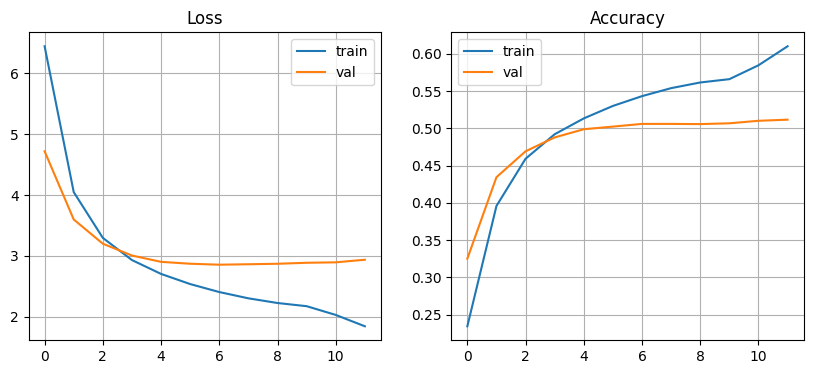

In [ ]:
def plot_history(h):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(h.history["loss"], label="train")
    ax[0].plot(h.history["val_loss"], label="val")
    ax[0].set_title("Loss")
    ax[0].legend(); ax[0].grid(True)

    ax[1].plot(h.history["accuracy"], label="train")
    ax[1].plot(h.history["val_accuracy"], label="val")
    ax[1].set_title("Accuracy")
    ax[1].legend(); ax[1].grid(True)
    plt.show()
print("Tăng các chỉ số!")
plot_history(history)

In [ ]:
# ================= CELL 6: BEAM SEARCH INFERENCE (BƯỚC 3) ==================

def beam_search_decoder(input_seq, k=3, max_len=40):
    start_id = y_tokenizer.word_index.get('startseq')
    end_id = y_tokenizer.word_index.get('endseq')
    if not start_id: return "Error: startseq missing"

    # Sequences: [(log_prob, [token_ids])]
    sequences = [[0.0, [start_id]]]

    for _ in range(max_len - 1):
        all_candidates = []
        for score, seq in sequences:
            if seq[-1] == end_id:
                all_candidates.append((score, seq))
                continue

            dec_input = pad_sequences([seq], maxlen=max_len-1, padding='post')
            preds = model.predict([input_seq, dec_input], verbose=0)

            # Lấy probs của từ tiếp theo (vị trí len(seq)-1)
            pred_probs = preds[0, len(seq)-1, :]

            # Top k
            top_k_idx = np.argsort(pred_probs)[-k:]
            for idx in top_k_idx:
                candidate_score = score + np.log(pred_probs[idx] + 1e-10)
                all_candidates.append((candidate_score, seq + [idx]))

        # Chọn k chuỗi tốt nhất
        sequences = sorted(all_candidates, key=lambda x: x[0], reverse=True)[:k]
        if all([s[1][-1] == end_id for s in sequences]): break

    best_seq = sequences[0][1]
    summary = y_tokenizer.sequences_to_texts([best_seq])[0]
    return summary.replace('startseq', '').replace('endseq', '').strip()

In [ ]:
def summarize_text(text):
    # Pipeline: Clean -> Tokenize -> Beam Search
    clean = clean_text(text, lowercase=True, mapping=contraction_mapping)
    seq = x_tokenizer.texts_to_sequences([clean])
    padded = pad_sequences(seq, maxlen=MAX_TEXT_LEN, padding='post')
    return beam_search_decoder(padded, k=3, max_len=MAX_SUMMARY_LEN)

In [ ]:
# ================= CELL 11 ==================
# 🧪 DEMO tóm tắt văn bản (LUÔN CHẠY LẠI khi test)
if __name__ == "__main__":
    test_article = """
    Sự kiện do Khối phụ trách đào tạo và trải nghiệm sinh viên Đại học RMIT Việt Nam tổ chức,
    thu hút hàng trăm đại biểu từ khắp Đông Nam Á và nhiều quốc gia khác, bao gồm diễn giả từ Đại học Công nghệ Sydney,
    Đại học RMIT Australia. Câu hỏi trọng tâm xuyên suốt hội thảo là \"Làm thế nào để đổi mới giáo dục thực sự cải thiện
    trải nghiệm học tập của sinh viên?\".\n\nHội thảo chia sẻ các sáng kiến đổi mới thực tiễn từ AI trong giáo dục đến học
    tập bao hàm và hợp tác với doanh nghiệp. Ảnh: RMIT\n\nHội thảo Tầm nhìn giáo dục đại học 2025 giới thiệu nhiều cách
    tiếp cận có tính kết nối, từ thiết kế học tập và khả năng tiếp cận đến công nghệ mới nổi, hợp tác với doanh nghiệp
    nhằm nâng cao kết quả học tập của sinh viên. Người tham dự có cơ hội trải nghiệm các dự án thực tế, nguyên mẫu đang
    được triển khai và những chiến lược đã kiểm chứng bằng thực tiễn, từng bước thay đổi các lớp học trên khắp khu vực.
    \n\nTích hợp Gen AI có chủ đích và liêm chính\n\nMột trong những điểm nhấn của hội thảo là bài tham luận chính của
    Phó giáo sư Amanda White đến từ Đại học Công nghệ Sydney (UTS). Là một nhà giáo có tầm ảnh hưởng từng nhận giải
    thưởng quốc gia về giảng dạy đại học tại Australia, bà đã đem đến góc nhìn toàn diện về việc tích hợp AI tạo sinh
    (Gen AI) có chiến lược vào giáo dục đại học.\n\n\"Gen AI là công cụ mạnh mẽ, nhưng giống như một chiếc đồng hồ thông minh,
    nên được sử dụng một cách chiến lược, không phải lúc nào cũng đem ra dùng. Chúng ta cần nghĩ xem đưa Gen AI vào đâu trong
    hệ thống giáo dục là phù hợp\", bà nói.\n\nPhó giáo sư White kêu gọi những người làm công tác giáo dục hướng dẫn để sinh viên
    dùng AI như công cụ hỗ trợ thay vì phụ thuộc. Bà trích lời của Giáo sư Angela Duckworth, tác giả sách Grit: Vững tâm
    bền chí ắt thành công, trong bài phát biểu dành cho tân khoa khóa 2025 của trường Sư phạm Sau đại học thuộc
    Đại học Pennsylvania (Penn GSE): \"Tôi lo rằng sinh viên sẽ dùng AI như một chiếc nạng. Tôi lo rằng vì não bộ
    con người giống như một nhóm cơ, sinh viên phải dùng thì nó mới săn chắc phát triển, nếu không dùng nó sẽ mất dần đi\".
    \n\nPhó giáo sư Amanda White từ Đại học Công nghệ Sydney (Australia) chia sẻ kinh nghiệm áp dụng Gen AI một cách chiến
    lược vào giáo dục đại học. Ảnh: RMIT\n\nCùng đề tài, bà đề cập thêm đến những nỗi lo và hiểu lầm phổ biến quanh Gen AI,
    từ việc lo ngại sản phẩm do công nghệ này tạo ra bị xem là gian lận đến hiện tượng \"AI slop\", rác do AI tạo ra trong các bài tập,
    cũng như những ý kiến kêu gọi cấm hoàn toàn trong giáo dục.\n\nPhó giáo sư White đề xuất một khung tích hợp Gen AI
    có mục tiêu rõ ràng trong giáo dục. Khung này gồm ba phần: minh bạch và niềm tin; gắn kết với kết quả học tập;
    công bằng và khả năng tiếp cận. Trong đó, minh bạch, niềm tin cần truyền thông rõ ràng về việc AI được dùng khi
    nào và như thế nào. Theo bà, việc gắn kết với kết quả học tập đảm bảo các công cụ AI sẽ hỗ trợ phát triển kỹ năng,
    thay vì thay thế. Đồng thời, nữ diễn giả nêu bật tầm quan trọng của sự công bằng và khả năng tiếp cận của việc biến
    AI thành công cụ hữu ích cho tất cả người học, kể cả những người có nhu cầu học tập đa dạng.\n\nBà dùng lớp kế toán
    dành cho sinh viên năm nhất tại UTS làm ví dụ minh chứng cho việc ứng dụng khung hành động này vào thực tế giảng dạy.
    Với hơn 1.800 sinh viên, Phó giáo sư White thiết kế lại bài viết tổng kết trải nghiệm cá nhân dùng công cụ Gen AI.
    Qua đó, sinh viên có thể tương tác sâu hơn với nội dung học và cải thiện kết quả, đặc biệt với nhóm có khác biệt
    trong cách học.\n\n\"Người làm giáo dục cần là tấm gương cho sinh viên về sự kiên cường, thấu cảm và tư duy phản biện,
    những kỹ năng mà AI không thể thay thế\", bà nhấn mạnh.\n\nHọc tập hợp tác\n\nBên cạnh tham luận của Phó giáo sư White,
    các đại biểu còn được tham dự vào tám thảo luận chuyên đề được tổ chức song song bởi các nhóm chuyên gia RMIT.
    Trong đó, phiên thảo luận \"Khám phá chân trời AI: Xu hướng hiện tại và tương lai\" của nhóm nghiên cứu
    Tương lai giáo dục đã giới thiệu về những công nghệ khác ngoài ChatGPT, bao gồm các mô hình suy luận,
    công cụ phát hiện deepfake và tích hợp thực tế ảo VR.\n\nSong song, tại phiên thảo luận
    \"Kết nối khả năng tiếp cận và thiết kế học tập\", cô Melanie Casul (Chăm sóc sức khỏe và tâm lý) và
    cô Nguyễn Ngọc Linh (Thiết kế học tập) chia sẻ về trường hợp một sinh viên khiếm thị tại RMIT Việt Nam. Theo đó,
    hai diễn giả chỉ ra rằng kế hoạch học tập đồng thiết kế, kết hợp giữa hỗ trợ của con người và các công cụ số, có thể
    giúp thu hẹp khoảng cách thế giới số đem lại.\n\nTiến sĩ Chu Thanh Tuấn, Phó chủ nhiệm bộ môn đến từ Khoa Kinh doanh,
    cũng dẫn dắt một phiên thảo luận về đổi mới bộ hồ sơ năng lực của sinh viên tốt nghiệp từ ngành Kinh doanh.
    Ông giới thiệu mô hình hợp tác với doanh nghiệp kéo dài suốt học kỳ gồm các kỳ thực tập ngắn và thử thách giải quyết
    các tình huống kinh doanh đang diễn ra trong thực tế, mang đến hướng tiếp cận có thể nhân rộng đối với đồ án cuối khóa
    mang tính thực tiễn.\n\nNhóm chuyên gia đưa ra giá trị của học tập suốt đời, mô hình giảng dạy linh hoạt và không gian
    học tập đồng sáng tạo để phản ánh những thách thức trong thế giới thực. Ảnh: RMIT\n\nNgoài ra, Tầm nhìn giáo dục đại học
    2025 có phiên thảo luận chuyên đề quy tụ các đại diện giới học thuật và doanh nghiệp, gồm: Phó giáo sư Amanda White,
    Phó giáo sư Donna Cleveland (RMIT Việt Nam) và ông Tường Trần (HEX). Phần chia sẻ của các diễn giả nhấn mạnh tầm quan
    trọng của học tập suốt đời, các mô hình học tập đa hình thức và kết hợp, cũng như nhu cầu cùng kiến tạo môi trường học
    tập phản ánh đúng thách thức thực tế.\n\nVới những nội dung trên, hội thảo giới thiệu về những công nghệ mới, đồng thời,
    kêu gọi hành động, khẳng định để đem đến thay đổi thực chất trong giáo dục, cần sự hợp tác, các phương pháp đã được kiểm
    chứng thực tế và cam kết bao hàm, khả năng tiếp cận.\n\nNhật Lệ
    """
    print("TÓM TẮT:", summarize_text(test_article))

TÓM TẮT: hội thảo khoa học công nghệ giáo dục đại học quốc gia hà nội đã tổ chức hội thảo khoa học công nghệ giáo dục quốc tế


🚀 Đang chọn ngẫu nhiên 4 bài để kiểm tra chi tiết...

⏳ Đang xử lý bài thứ 1/4 (Index: 1152)...


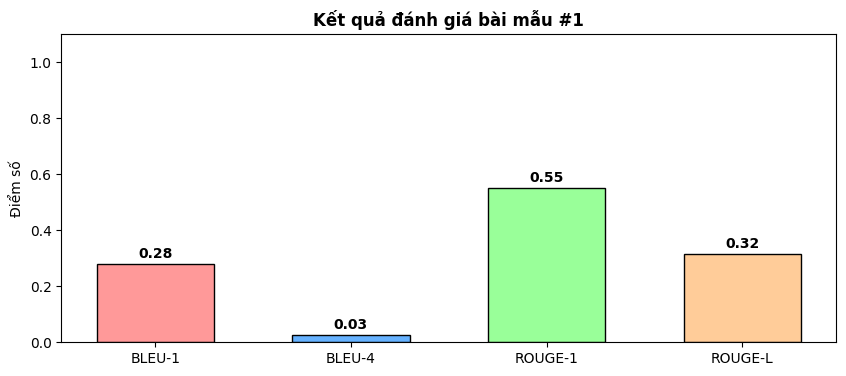

📖 [NỘI DUNG GỐC]: trong đó bạc liêu công bố đầu tiên hôm 3 6 tỉnh này tổ chức thi lớp 10 sớm nhất cả nước vào ngày 22 23 5 tiếp đó là lai châu 8 6 còn lại phần lớn dự kiến lịch báo điểm thi điểm chuẩn lớp 10 trong khoả...
🎯 [TÓM TẮT GỐC]: gần 50 địa phương dự kiến công bố điểm thi điểm chuẩn lớp 10 vào giữa tháng 6 riêng bình phước đến 15 8
🤖 [MÁY TÓM TẮT]: điểm chuẩn vào lớp 10 năm học 2025 2026 của tỉnh bạc liêu cao nhất cả nước có hơn 1 000 thí sinh dự thi
--------------------------------------------------------------------------------

⏳ Đang xử lý bài thứ 2/4 (Index: 1237)...


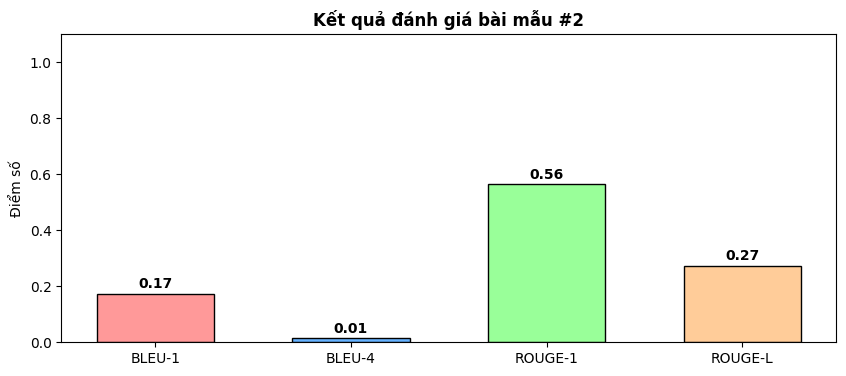

📖 [NỘI DUNG GỐC]: sinh ngô gia phong trải lòng thủ khoa ngô gia phong chia sẻ em gặp lực áp lực đồng trang lứa khi bước vào đại học gặp nhiều bạn vừa giỏi vừa hiểu biết năm học 2024 2025 trường đại học quốc tế đón gần ...
🎯 [TÓM TẮT GỐC]: tân sinh viên ngô gia phong thủ khoa đầu vào trường đại học quốc tế đại học quốc gia tphcm theo phương thức điểm đánh giá năng lực thừa nhận bị áp lực khi thấy nhiều bạn vừa giỏi vừa hiểu biết
🤖 [MÁY TÓM TẮT]: trong kỳ thi tốt nghiệp trung học phổ thông năm 2022 nhiều sinh viên xuất sắc giành học bổng 100 vào đại học danh giá nhất nước mỹ
--------------------------------------------------------------------------------

⏳ Đang xử lý bài thứ 3/4 (Index: 648)...


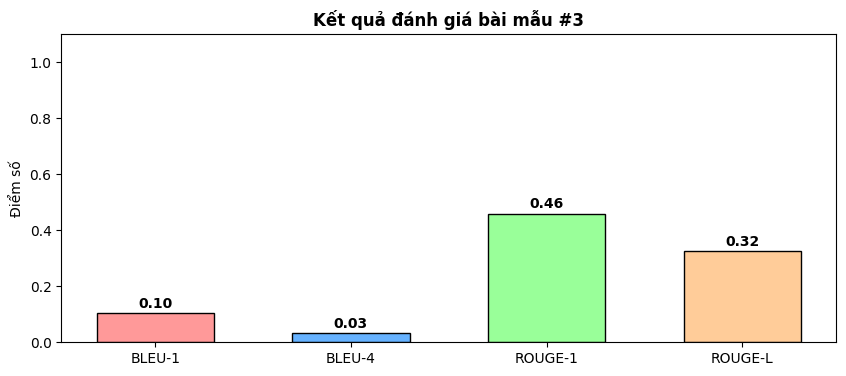

📖 [NỘI DUNG GỐC]: muốn thể hiện quan điểm trước những cuộc xung đột trên thế giới nhưng chính phủ mỹ đánh giá những động thái này không có lợi cho mỹ hay cho môi trường học thuật trong các trường đại học thời gian qua ...
🎯 [TÓM TẮT GỐC]: đại học harvard phản đối gay gắt quyết định này và gọi động thái này là một sự trả đũa đi ngược lại quy định của pháp luật
🤖 [MÁY TÓM TẮT]: đại học harvard mỹ đã bị cấm việc làm việc tại mỹ để làm việc tại đại học harvard gây tranh cãi
--------------------------------------------------------------------------------

⏳ Đang xử lý bài thứ 4/4 (Index: 1276)...


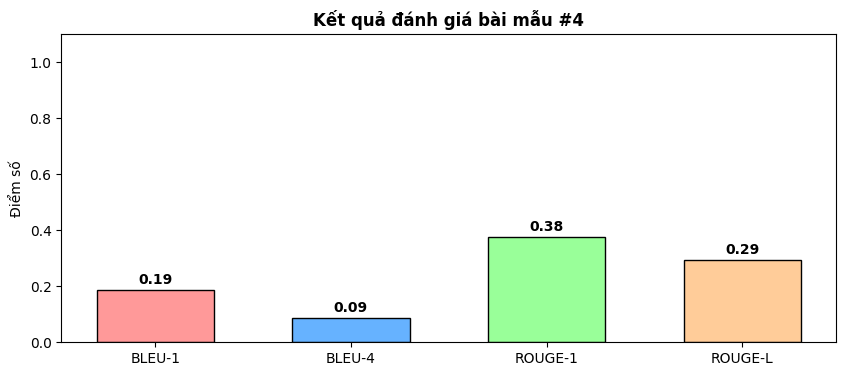

📖 [NỘI DUNG GỐC]: giáo sư cho biết quan điểm của mình về ý kiến được cho là có phần cực đoan thái quá này để nói một ai đó là rởm hay thật thì cần dựa vào tiêu chí nào đó chúng ta đang tiến đến có một tiêu chí mà cả xã...
🎯 [TÓM TẮT GỐC]: giáo sư phó giáo sư có hiện tượng vơ bèo vạt tép tuy nhiên nhiệm vụ của các hội đồng cơ sở hội đồng ngành hội đồng chức danh giáo sư nhà nước chính là phân biệt cho được những người đạt chuẩn nhờ bèo tép như vậy
🤖 [MÁY TÓM TẮT]: giáo sư phó giáo sư tiến sĩ nguyễn thị minh sơn trưởng khoa giáo sư phó giáo sư phó giáo sư phó giáo sư tiến sĩ nguyễn văn minh là phó giáo sư phó giáo sư phó giáo sư tiến sĩ nguyễn văn minh đã công nhận được
--------------------------------------------------------------------------------



In [ ]:
# ================= CELL: ĐÁNH GIÁ & VẼ BIỂU ĐỒ TỪNG BÀI (INDIVIDUAL PLOT) =================
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

def evaluate_and_plot_individuals(num_samples=4):
    print(f"🚀 Đang chọn ngẫu nhiên {num_samples} bài để kiểm tra chi tiết...\n")

    # 1. Chọn index ngẫu nhiên
    indices = np.random.choice(len(x_val), num_samples, replace=False)

    # Khởi tạo công cụ tính điểm
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smooth = SmoothingFunction().method1

    start_token = y_tokenizer.word_index.get('startseq')
    end_token = y_tokenizer.word_index.get('endseq')

    for count, idx in enumerate(indices):
        print(f"⏳ Đang xử lý bài thứ {count + 1}/{num_samples} (Index: {idx})...")

        # --- A. LẤY DỮ LIỆU ---
        # 1. Input Sequence
        input_seq = x_val[idx:idx+1]

        # 2. Lấy nội dung bài viết gốc (để hiển thị)
        source_text = x_tokenizer.sequences_to_texts(input_seq)[0]
        source_text = source_text.replace('<OOV>', '').strip()

        # 3. Lấy tóm tắt gốc (Ground Truth)
        target_seq = [t for t in y_val_out[idx] if t > 0]
        true_summary = y_tokenizer.sequences_to_texts([target_seq])[0]
        true_summary = true_summary.replace('startseq', '').replace('endseq', '').strip()

        # --- B. DỰ ĐOÁN (SINH TÓM TẮT) ---
        curr_seq = np.zeros((1, MAX_SUMMARY_LEN - 1))
        curr_seq[0, 0] = start_token
        pred_words = []

        for t in range(MAX_SUMMARY_LEN - 2):
            preds = model.predict([input_seq, curr_seq], verbose=0)
            pred_id = np.argmax(preds[0, t, :])

            if pred_id == end_token or pred_id == 0:
                break

            word = y_tokenizer.index_word.get(pred_id, "")
            pred_words.append(word)
            curr_seq[0, t + 1] = pred_id

        pred_summary = " ".join(pred_words).strip()

        # --- C. TÍNH ĐIỂM RIÊNG BÀI NÀY ---
        scores = {}
        ref_tokens = true_summary.split()
        hyp_tokens = pred_summary.split()

        if not hyp_tokens: # Nếu máy không dự đoán được gì
            scores = {'BLEU-1': 0, 'BLEU-4': 0, 'ROUGE-1': 0, 'ROUGE-L': 0}
        else:
            # BLEU
            scores['BLEU-1'] = sentence_bleu([ref_tokens], hyp_tokens, weights=(1,0,0,0), smoothing_function=smooth)
            scores['BLEU-4'] = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth)
            # ROUGE
            r_scores = scorer.score(true_summary, pred_summary)
            scores['ROUGE-1'] = r_scores['rouge1'].fmeasure
            scores['ROUGE-L'] = r_scores['rougeL'].fmeasure

        # --- D. VẼ BIỂU ĐỒ & HIỂN THỊ ---
        plt.figure(figsize=(10, 4))

        # Vẽ cột
        metrics = list(scores.keys())
        values = list(scores.values())
        colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

        bars = plt.bar(metrics, values, color=colors, edgecolor='black', width=0.6)
        plt.ylim(0, 1.1)
        plt.title(f"Kết quả đánh giá bài mẫu #{count+1}", fontweight='bold')
        plt.ylabel("Điểm số")

        # Hiện số trên cột
        for bar in bars:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                     f"{bar.get_height():.2f}", ha='center', fontweight='bold')

        plt.show()

        # In văn bản so sánh
        print(f"📖 [NỘI DUNG GỐC]: {source_text[:200]}...") # In 200 ký tự đầu
        print(f"🎯 [TÓM TẮT GỐC]: {true_summary}")
        print(f"🤖 [MÁY TÓM TẮT]: {pred_summary}")
        print("-" * 80 + "\n")

# Chạy hàm
evaluate_and_plot_individuals(num_samples=4)